In [3]:
from bs4 import BeautifulSoup
import requests
import unicodedata
from csv import writer
import re
import pandas as pd
import numpy as np
import json


#spark session
from pyspark.sql import SparkSession
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql import functions as F


import os
import re 

#folium
import geopandas as gpd
import re
import folium

In [4]:

output_dir = '../../data/curated/domain-website-data'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [5]:
# Create a spark session

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .getOrCreate()
)

# read in the parquet
domain = spark.read.parquet('../../data/raw/domain-website-data')


22/09/25 01:44:22 WARN Utils: Your hostname, haixindeMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.14 instead (on interface en0)
22/09/25 01:44:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/25 01:44:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/25 01:44:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [6]:
# drop NSW
domain = domain.filter(F.col('state') == 'VIC')

# drop column with too many missing values
domain = domain.drop('land_size','land_unit','is_rural','is_retirement').toPandas()

# filter property type, remove 'cat spcae' and 'Acreage / Semi-Rural'
selected_property_type = ['Apartment / Unit / Flat', 'Studio', 'Townhouse',
       'House', 'New House & Land', 'Semi-Detached', 'Villa', 'Terrace',
       'Acreage / Semi-Rural', 'New Apartments / Off the Plan', 'Duplex',
       'Unknown', 'Farm', 'Penthouse', 'Rural']

domain= domain.loc[domain['property_type'].isin(selected_property_type)]

In [7]:
#remove instance with 'carpark' in street name
def carpark_flag(s):
    pattern = re.compile('carpark|CP|car park|carspace')
    match = re.match(pattern,s)
    #o for non carpark, 1 for carpark
    if match is None:
        return 0
    else:
        return 1

In [8]:
def get_rent(s):
    pattern = re.compile('^( )*([0-9]*)( )*')
    num = re.sub('(,)?', '',s)
    num = re.sub('[^0-9]+', ' ',num)
    match = re.match(pattern,num)[0].replace(" ", "")

    if match !='':
        return match
    else:
        return 0

In [9]:
domain['street'] = domain['street'].str.lower()
domain['carpark_flag'] = [carpark_flag(i) for i in domain['street']]
domain['price_rent'] = [float(get_rent(i)) for i in domain['price']]
domain['coordinate'] = domain[['latitude','longitude']].values.tolist()

In [10]:
# exclude instance with no street name
domain = domain[(domain.street != 'nan')]

# exclude car park instance
domain = domain[(domain.carpark_flag != 1) & (domain.price_rent > 40)]

# remove property without bathroom or bedroom
domain = domain[(domain.bedrooms != 0) & (domain.bathrooms != 0)]

# remove property greater than 4000 pw
domain = domain[(domain.price_rent < 4000)]

# remove property outside VIC
domain = domain[(domain.state == 'VIC')]

#remove duplicate property
domain = domain.drop_duplicates(subset='url', keep="first")

In [11]:
'''

remove postcode not within metro melbourne


'''
metro_list = [i for i in range(3000,3212)]+[3335,3336,3338]+[i for i in range(3427,3430)]\
                +[i for i in range(3750,3756)]+[i for i in range(3759,3762)]\
                +[i for i in range(3765,3776)] +[i for i in range(3781,3788)]\
                +[i for i in range(3788,3816)] +[i for i in range(3910,3921)]\
                +[i for i in range(3926,3945)] +[i for i in range(3975,3979)] +[3980] #308 postcodes

domain_spk = spark.createDataFrame(domain)
domain_spk = domain_spk.filter(domain_spk.postcode.isin(metro_list))

In [12]:
count_agg = domain_spk.groupby('postcode').count()\
            .withColumnRenamed("postcode","postcode_1")\
            .withColumnRenamed("count","postcode_property_count") #233 postcodes

In [13]:
'''

add count by postcode 

remove postcode with less than 10 property

'''

count_agg = domain_spk.groupby('postcode').count()\
            .withColumnRenamed("postcode","postcode_1")\
            .withColumnRenamed("count","postcode_property_count")
domain_spk = domain_spk.join(count_agg,domain_spk.postcode == count_agg.postcode_1,"inner").drop('postcode_1')

# remove postcode with less than 10 property
domain_spk = domain_spk.filter((F.col('postcode_property_count') > 10))
domain_spk.groupby('postcode').count().count() #180 postcodes remains

180

In [14]:
domain = domain_spk.toPandas()
domain = domain.drop(columns = ['carpark_flag','state'])
domain

,property_id,street,suburb,postcode,latitude,longitude,price,bedrooms,bathrooms,parking,property_type,url,price_rent,coordinate,postcode_property_count
0,15949214,33 cindia crescent,TARNEIT,3029,-37.836800,144.681992,$410,3,2,2,House,https://www.domain.com.au/33-cindia-crescent-t...,410.0,"[-37.8368, 144.681992]",264
1,15919137,3 loire close,HOPPERS CROSSING,3029,-37.858776,144.670990,$420,4,2,2,House,https://www.domain.com.au/3-loire-close-hopper...,420.0,"[-37.8587761, 144.67099]",264
2,15598556,5 toscana,TRUGANINA,3029,-37.831726,144.721200,$440,4,2,2,New House & Land,https://www.domain.com.au/5-toscana-truganina-...,440.0,"[-37.8317261, 144.7212]",264
3,15513398,12 sussex court,TARNEIT,3029,-37.850758,144.712234,$415 per week,3,3,1,House,https://www.domain.com.au/12-sussex-court-tarn...,415.0,"[-37.8507576, 144.712234]",264
4,15500954,4a craig close,TRUGANINA,3029,-37.843980,144.717514,$410 per week,3,2,1,House,https://www.domain.com.au/4a-craig-close-truga...,410.0,"[-37.84398, 144.717514]",264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12122,16059419,15/26 green island avenue,MOUNT MARTHA,3934,-38.248100,145.041611,$625 per week,3,2,2,Townhouse,https://www.domain.com.au/15-26-green-island-a...,625.0,"[-38.2481, 145.041611]",13
12123,16047477,8 raymond street,MOUNT MARTHA,3934,-38.285440,144.995331,$720 weekly,4,2,2,House,https://www.domain.com.au/8-raymond-street-mou...,720.0,"[-38.28544, 144.995331]",13
12124,16034036,15 whitsunday ct,MOUNT MARTHA,3934,-38.250070,145.052078,$700 weekly,4,2,2,House,https://www.domain.com.au/15-whitsunday-ct-mou...,700.0,"[-38.25007, 145.052078]",13
12125,15957808,107 forest dr,MOUNT MARTHA,3934,-38.290226,145.016418,$870 weekly,3,2,2,House,https://www.domain.com.au/107-forest-dr-mount-...,870.0,"[-38.290226, 145.016418]",13


In [16]:
# output cleaned domain dataset
output_dir = '../../data/curated/domain-website-data/'
filename = 'domain_preprocessed.csv'
output_dir_full = f'{output_dir}{filename}'
domain.to_csv(output_dir_full)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The price_rent skewness is 4.47


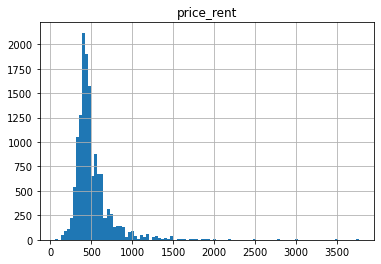

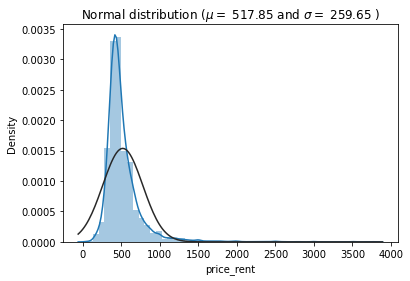

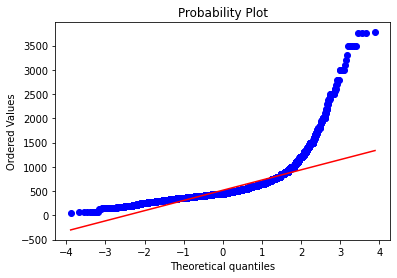

In [700]:
# see where properties are distributed
domain = domain_spk.toPandas()
domain.hist(column='postcode_property_count',bins=100)
domain['postcode_property_count'].describe()



# plot price against normal distribution to see skewness
import seaborn as sns
from scipy import stats

# plot rental price to see outliers
domain.hist(column='price_rent',bins=100)

# info about rental price
domain['price_rent'].describe()

def skew_distribution(data, col='price_rent'):
    fig, ax1 = plt.subplots()
    sns.distplot(data[col], ax=ax1, fit=stats.norm)
    (mu, sigma) = stats.norm.fit(data[col])
    ax1.set(title='Normal distribution ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma))

    fig, ax2 = plt.subplots()
    stats.probplot(data[col], plot=plt)

    print('The {} skewness is {:.2f}'.format(col, stats.skew(data[col])))
    
skew_distribution(domain, col='price_rent')
